In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_215405/912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

In [3]:
def get_speed(df_row):
    gps_ast = ast.literal_eval(df_row['gps_can_data'])
    if 'speed' in gps_ast:
        return gps_ast['speed']
    else:
        return np.nan

In [4]:
def merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df):
    print('master_df', master_df.shape)
    df = master_df[['id', 'collected_on', 'camera_location', 'operation_time', 'geohash']]
    
    # merge with label_df
    df = df.merge(label_df, on='id', how='left')
    df = df.fillna(0)
    print('merge label counts', df.shape)

    # load prediction on unlabeled data to get dust ratios
    print('unlabeled_pred_df', unlabeled_pred_df.shape)
    if not 'total_averaged_dust_ratio' in unlabeled_pred_df and 'total_averaged_dust_conf' in unlabeled_pred_df:
        unlabeled_pred_df['total_averaged_dust_ratio'] = unlabeled_pred_df['total_averaged_dust_conf']
        unlabeled_pred_df['triangle_averaged_dust_ratio'] = unlabeled_pred_df['masked_avg_dust_conf']
        df = df.merge(unlabeled_pred_df[['id', 'total_averaged_dust_ratio', 'triangle_averaged_dust_ratio']], on='id')
    if 'total_averaged_dust_ratio' in unlabeled_pred_df:
        df = df.merge(unlabeled_pred_df[['id', 'total_averaged_dust_ratio', 'triangle_averaged_dust_ratio']], on='id')
    if 'pred_dust_ratio' in unlabeled_pred_df:  # GRETZKY_1385_dust_head branch
        unlabeled_pred_df['pred_dust_ratio'] /= 100
        df = df.merge(unlabeled_pred_df[['id', 'pred_dust_ratio']], on='id')
    print('merge unlabeled dust ratios', df.shape)

    # load prediction on labeled data to get the prediction "state"
    print('labeled_pred_df', labeled_pred_df.shape)
    # convert LO states to regular states and fill empty states with TNs
    df = df.merge(labeled_pred_df[['id', 'state']], on='id', how='left').drop_duplicates(subset=['id'])
    df = df.fillna('true_negative')
    df = df.replace('large_object_true_positive', 'true_positive')
    df = df.replace('large_object_false_negative', 'false_negative')
    print('merge labeled states', df.shape)

    # sort by time and add datetime column
    df = df.sort_values('collected_on')
    df['datetime'] = df.collected_on.apply(datetime.fromisoformat)
    df['datehm'] = df.collected_on.apply(lambda x:str(x)[:16])
    print('final_df', df.shape)
    print('# TPs', len(df[df.state == 'true_positive']), '# Positives', len(df[(df.state == 'true_positive') | (df.state == 'false_negative')]))
    df['speed'] = master_df.apply(get_speed, axis=1)
    
    return df

## Load example df

In [5]:
data_root_dir = '/data/jupiter/li.yu/data'
unlabeled_datasets = ["Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2", 
                      "Jupiter_2023_04_05_loamy869_dust_collection_stereo", 
                      "Jupiter_2023_may_loamy731_vehicle_dust_human_stereo"]
labeled_datasets = [["Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled", 
                    "Jupiter_2023_March_29th30th_human_vehicle_in_dust_front_pod_labeled"], 
                    ["Jupiter_2023_04_05_loamy869_dust_collection_stereo_labeled"], 
                    ["Jupiter_2023_may_loamy731_vehicle_dust_human_stereo_labeled"]]
pred_root = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
train_id = 'dust_51_v188_58d_rak_local_fine_tversky11_sum_image_normT_prod5_airdyn_r3a8_s30'
# train_id = 'v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305'
rear_pod_model = False   # True for 4-class, False for 7 or 8 class models

# set 1
dfs = []
for i in range(len(labeled_datasets)):
    master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
    label_df_unmerged = [
        pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i][j], 'label_count.csv'))
        for j in range(len(labeled_datasets[i]))
    ]
    label_df = pd.concat(label_df_unmerged, ignore_index=True)
    if rear_pod_model:
        unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i], 'dust_ratio.csv'))
    else:
        unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i], 'output.csv'))
    labeled_pred_df_unmerged = [
        pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i][j], 'output.csv'))
        for j in range(len(labeled_datasets[i]))
    ]
    labeled_pred_df = pd.concat(labeled_pred_df_unmerged, ignore_index=True)
    dfs.append(merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df))

df = pd.concat(dfs, ignore_index=True)
print('merge all three sets (double df3 as it is halved) to get df', df.shape)
pdf = df[(df.state == 'true_positive') | (df.state == 'false_negative')]
print('positive images', pdf.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/data/jupiter/li.yu/data/Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2/master_annotations.csv'

In [6]:
# 4 class models
train_id = 'v57rd_4cls_tiny0occluded5reverse5triangle5_msml_0305'
unlabeled_datasets = ["Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2", 
                      "Jupiter_2023_04_05_loamy869_dust_collection_stereo", 
                      "Jupiter_2023_may_loamy731_vehicle_dust_human_stereo"]
labeled_datasets = ["Jupiter_2023_03_02_and_2930_human_vehicle_in_dust_labeled", 
                    "Jupiter_2023_March_29th30th_human_vehicle_in_dust_front_pod_labeled", 
                    "Jupiter_2023_04_05_loamy869_dust_collection_stereo_labeled", 
                    "Jupiter_2023_may_loamy731_vehicle_dust_human_stereo_labeled"]

# set 1
i = 0
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df1 = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i], 'label_count.csv'))
label_df2 = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
label_df = pd.concat([label_df1, label_df2], ignore_index=True)
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43_newmask', 'dust_ratio.csv'))
labeled_pred_df1 = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i]+'_epoch43', 'output.csv'))
labeled_pred_df2 = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
labeled_pred_df = pd.concat([labeled_pred_df1, labeled_pred_df2], ignore_index=True)
df1 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

# set 2
i = 1
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43', 'dust_ratio.csv'))
labeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
df2 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

# set 3
i = 2
master_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[i], 'master_annotations.csv'), low_memory=False)
label_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[i+1], 'label_count.csv'))
unlabeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, unlabeled_datasets[i]+'_epoch43', 'dust_ratio.csv'))
labeled_pred_df = pd.read_csv(os.path.join(pred_root, train_id, labeled_datasets[i+1]+'_epoch43', 'output.csv'))
df3 = merge_meta_with_pred(master_df, label_df, unlabeled_pred_df, labeled_pred_df)

df = pd.concat([df1, df2, df3], ignore_index=True)
print('merge all three sets (double df3 as it is halved) to get df', df.shape)
pdf = df[(df.state == 'true_positive') | (df.state == 'false_negative')]
print('positive images', pdf.shape)

# df = df2
dfs = [df1, df2, df3]

FileNotFoundError: [Errno 2] No such file or directory: '/data/jupiter/li.yu/data/Jupiter_2023_03_29_10pm_30_3pm_Loamy_812_stops_stereo_2/master_annotations.csv'

In [7]:
df = pd.read_csv('/home/alexli/logs/summary_7204_vehicles.csv')

In [9]:
cameras = ['rear', 'side']
cameras = ['rear_side']
windows = ['_5s', '']

In [11]:
df.sample(5)
df['total_averaged_dust_ratio'] = df['dust_percent']
df['triangle_averaged_dust_ratio'] = df['dust_percent']

In [17]:
def get_state(row):
    pred = row['predicted_stop_class']
    label = row['label_stop_class']
    if pred and label:
        if label:
            return 'true_positive'
        else:
            return 'false_positive'
    else:
        if label:
            return 'false_negative'
        else:
            return 'false_positive'

df['state'] = df.apply(get_state,axis=1)

## Extract average/maximum delta_t between two successive TPs

In [18]:
def get_sequences(df, interval=5*60, per_camera=False):
    df = df.sort_values('collected_on')
    df['datetime'] = df.collected_on.apply(datetime.fromisoformat)
    sequence_dfs = []
    delta = timedelta(seconds=interval)
    start = True
    i0, i = 0, 0
    while i < len(df):
        if start:
            t0 = df.iloc[i].datetime
            start = False
        else:
            t1 = df.iloc[i].datetime
            if t1 - t0 > delta or i == len(df) - 1:
                chunk_df = df.iloc[i0 : i if i < len(df) - 1 else len(df)]
                if per_camera:
                    camera_locations = chunk_df.camera_location.unique()
                    camera_locations.sort()
                    for camera_location in camera_locations:
                        sequence_df = chunk_df[chunk_df.camera_location == camera_location]
                        sequence_df = sequence_df.sort_values('collected_on')
                        sequence_dfs.append(sequence_df)
                else:
                    sequence_dfs.append(chunk_df)
                start = True
                i0 = i
            else:
                t0 = t1
        i += 1
    return sequence_dfs

def get_avg_dust_ratio_and_delta_t_helper(df, states, cameras, window_sizes, step_sizes):
    def get_results_for_a_df(df, camera, state_col_idx=13, t=None, window=None):
        avg_dust_ratio, avg_delta_t, max_delta_t = None, None, None
        dust_key = 'triangle_averaged_dust_ratio' if camera == 'rear' else 'total_averaged_dust_ratio'
        tp_df = df[df.state == 'true_positive']
        if len(tp_df) == 0:
            avg_dust_ratio = df[dust_key].mean()  # avg dust ratio of TNs and TPs
        else:
            avg_dust_ratio = tp_df[dust_key].mean()  # avg dust ratio of TPs
        # set begin and end states of df to TP
        if t is not None and len(tp_df) == 0 and \
            (df.iloc[0].datetime - t).total_seconds() < 0.5 and \
            (t + window - df.iloc[-1].datetime).total_seconds() < 0.5:
            avg_delta_t = max_delta_t = window.total_seconds() + 2
#             print(t, (df.iloc[0].datetime - t).total_seconds(), (t + window - df.iloc[-1].datetime).total_seconds())
        else:
            df_copy = df.copy()
            df_copy.iat[0, state_col_idx] = df_copy.iat[len(df_copy)-1, state_col_idx] = 'true_positive'
            df_copy = df_copy[df_copy.state == 'true_positive']
            if len(df_copy) > 1:
                delta_ts = [(df_copy.iloc[i].datetime - df_copy.iloc[i-1].datetime).total_seconds() for i in range(1, len(df_copy))]
                avg_delta_t = sum(delta_ts) / len(delta_ts)
                max_delta_t = max(delta_ts)
        return avg_dust_ratio, avg_delta_t, max_delta_t
    
    def get_avg_max_dust_ratio(df, interval):
        max_dust_ratios = []
        seq_dfs = get_sequences(df, interval, per_camera=False)
        for seq_df in seq_dfs:
            cameras = seq_df.camera_location.to_list()
            take_every = False
            if len(set(cameras)) < len(cameras):
                take_every = True
            dust_ratios = []
            for i,row in seq_df.iterrows():
#                 if row.state == 'true_positive':
                if row.camera_location.startswith('rear'):
                    dust_ratio = row.triangle_averaged_dust_ratio
                else:
                    dust_ratio = row.total_averaged_dust_ratio
                dust_ratios.append(dust_ratio)
            if dust_ratios:
                if take_every:
                    max_dust_ratios += dust_ratios
                else:
                    max_dust_ratios.append(max(dust_ratios))
        if max_dust_ratios:
            return sum(max_dust_ratios) / len(max_dust_ratios)
        else:
            return None
    
    def process_by_sliding_window(df, states, camera, window_size, step_size):
        window = timedelta(seconds=window_size)
        step = timedelta(seconds=step_size)
        ts = df.iloc[0].datetime
        te = df.iloc[-1].datetime
        t = ts
        window_states = defaultdict(list)
        while t + window <= te:
            sub_df = df[(df.datetime >= t) & (df.datetime < t+window)]
            if len(sub_df) <= 2:
                t += step
                continue
            avg_dust_ratio, avg_delta_t, max_delta_t = get_results_for_a_df(sub_df, camera, state_col_idx, t, window)
            if camera == 'rear_side':
                avg_dust_ratio = get_avg_max_dust_ratio(sub_df, 0.1)
            if avg_dust_ratio is not None:
                window_states[f'avg_dust_ratio_{camera}_{window_size}s'].append(avg_dust_ratio)
                window_states[f'avg_delta_t_{camera}_{window_size}s'].append(avg_delta_t if avg_delta_t is not None else window_size)
                window_states[f'max_delta_t_{camera}_{window_size}s'].append(max_delta_t if max_delta_t is not None else window_size)
            t += step
        states[f'avg_dust_ratio_{camera}_{window_size}s'].append(window_states[f'avg_dust_ratio_{camera}_{window_size}s'])
        states[f'avg_delta_t_{camera}_{window_size}s'].append(window_states[f'avg_delta_t_{camera}_{window_size}s'])
        states[f'max_delta_t_{camera}_{window_size}s'].append(window_states[f'max_delta_t_{camera}_{window_size}s'])
    
    state_col_idx = df.columns.values.tolist().index('state')
    for camera in cameras:
        # overall metrics
        avg_dust_ratio = None
        if camera == 'rear_side':
            camera_df = df
        else:
            camera_df = df[df.camera_location.str.startswith(camera)]
        if len(camera_df) > 2:
            avg_dust_ratio, avg_delta_t, max_delta_t = get_results_for_a_df(camera_df, camera, state_col_idx)
            if camera == 'rear_side':
                avg_dust_ratio = get_avg_max_dust_ratio(camera_df, 0.1)

            assert avg_dust_ratio is not None 
            if avg_dust_ratio is not None:
                states[f'avg_dust_ratio_{camera}'].append(avg_dust_ratio)
                states[f'avg_delta_t_{camera}'].append(avg_delta_t)
                states[f'max_delta_t_{camera}'].append(max_delta_t)
            # process in sliding windows
            for window_size, step_size in zip(window_sizes, step_sizes):
                process_by_sliding_window(camera_df, states, camera, window_size, step_size)
    return states

def get_avg_dust_ratio_and_delta_t(df, window_size=5, step_size=1):
    tp_states = {}
    window_sizes = [0, window_size]
    step_sizes = [0, step_size]
    for camera in cameras:
        for window_size in window_sizes:
            window_key = f'_{window_size}s' if window_size > 0 else ''
            tp_states[f'avg_dust_ratio_{camera}{window_key}'] = []
            tp_states[f'avg_delta_t_{camera}{window_key}'] = []
            tp_states[f'max_delta_t_{camera}{window_key}'] = []
    tpfn_df = df[(df.state == 'true_positive') | (df.state == 'false_negative')]
    print('  tpfn_df', tpfn_df.shape)
    if len(tpfn_df) > 2:
        get_avg_dust_ratio_and_delta_t_helper(tpfn_df, tp_states, cameras, window_sizes[1:], step_sizes[1:])
    return tp_states

In [19]:
fix = {
    '2023-03-29T22:23:46.331000': [0,-1], '2023-03-29T22:25:47.441000': [-2,-1], '2023-03-29T22:27:43.387000': [], '2023-03-29T22:29:30.005000': [-1], 
    '2023-03-29T22:32:39.504000': [], '2023-03-29T22:34:23.394000': [], '2023-03-29T22:36:12.145000': [-1], '2023-03-29T22:38:10.259000': [], 
    '2023-03-29T22:45:01.713000': [-10000], '2023-03-29T23:45:30.666000': [0,-1], '2023-03-29T23:47:11.274000': [-1], '2023-03-29T23:49:12.248000': [], 
    '2023-03-29T23:51:06.362000': [], '2023-03-29T23:55:11.838000': [0], '2023-03-29T23:57:10.445000': [], '2023-03-29T23:58:54.361000': [], 
    '2023-03-30T00:00:58.719000': [], '2023-03-30T00:05:36.223000': [], '2023-03-30T00:07:33.158000': [], '2023-03-30T00:09:19.825000': [], 
    '2023-03-30T00:11:10.935000': [], '2023-03-30T00:11:26.189000': [], '2023-03-30T00:11:43.140000': [], '2023-03-30T00:12:00.133000': [], 
    '2023-03-30T00:21:15.258000': [-10000], '2023-03-30T00:28:39.895000': [-10000], '2023-03-30T00:32:33.586000': [-10000], '2023-03-30T01:30:55.446000': [], 
    '2023-03-30T01:31:09.871000': [], '2023-03-30T01:32:35.611000': [], '2023-03-30T01:32:52.360000': [], '2023-03-30T01:34:33.331000': [], 
    '2023-03-30T01:36:20.737000': [], '2023-03-30T01:36:39.402000': [], '2023-03-30T01:37:16.698000': [], '2023-03-30T01:37:32.989000': [], 
    '2023-03-30T01:37:48.514000': [], '2023-03-30T01:42:00.564000': [], '2023-03-30T01:43:44.675000': [], '2023-03-30T01:43:59.645000': [], 
    '2023-03-30T01:44:16.047000': [], '2023-03-30T01:45:38.975000': [], '2023-03-30T01:45:55.040000': [-3,-2,-1], '2023-03-30T01:47:31.482000': [-1], 
    '2023-03-30T01:49:14.488000': [], '2023-03-30T01:53:39.161000': [-10000], '2023-03-30T01:55:03.401000': [0,1,2,3,4,5,6,7,8], '2023-03-30T01:55:17.966000': [], 
    '2023-03-30T01:57:21.863000': [-1], '2023-03-30T01:59:07.979000': [-5000], '2023-03-30T02:14:11.643000': [-10000], '2023-03-30T02:15:48.603000': [-10000], 
    '2023-03-30T02:18:01.084000': [-10000]
}

In [21]:
seq_dfs = get_sequences(df, interval=5, per_camera=False)
print(len(seq_dfs), 'sequences')

avg_dust_ratio_and_delta_t = {}

for i, seq_df in enumerate(seq_dfs):
    if 'total_averaged_dust_ratio' not in seq_df.columns:
        # idk where these columns are
        seq_df['total_averaged_dust_ratio'] = seq_df.pred_dust_ratio
        seq_df['triangle_averaged_dust_ratio'] = seq_df.pred_dust_ratio
    fp_df = seq_df[(seq_df.state == 'true_positive') | (seq_df.state == 'false_negative')]
    fp_cnt = len(fp_df)
    dust_cnt = len(seq_df[seq_df.total_averaged_dust_ratio >= 0.15])
    if fp_cnt > 0 and dust_cnt > 0:
        # print(i+1, seq_df.iloc[0].datehm, seq_df.iloc[-1].datehm, seq_df.iloc[0].camera_location, fp_cnt, 'FPs in', len(seq_df), 'images, dusty image count', dust_cnt)

        # refine points
        name = seq_df.iloc[0].collected_on  # use time of original sequence to saved image name
        # if not name in fix:
        #     continue
        if name in fix:
            notes = fix[name]
            if notes:
                if notes[0] == -10000:
                    continue
                elif notes[0] == -5000:
                    fp_df = fp_df.head(n=len(fp_df)//2)
                else:
                    pos = [idx for idx in notes if idx >= 0]
                    neg = [idx for idx in notes if idx < 0]
                    if pos:
                        fp_df = fp_df.iloc[pos[-1]+1:]
                    if neg:
                        fp_df = fp_df.iloc[:neg[0]]

        # plot individual sequnces
        # try:
        #     save_path = os.path.join(save_dir, name+'.png')
        #     plot_dust_ratio_and_state_rear_pod(fp_df, save_path, plot_in_one=true, only_positive=true, labeled_states=true)
        # except:
        #     print(i+1, name)
        
        # process and get average dust ratios and delta_ts
        tp_states = get_avg_dust_ratio_and_delta_t(fp_df)
        avg_dust_ratio_and_delta_t[name] = [tp_states]

49 sequences
  tpfn_df (110, 35)
  tpfn_df (148, 35)
  tpfn_df (122, 35)
  tpfn_df (111, 35)
  tpfn_df (10, 35)
  tpfn_df (21, 35)
  tpfn_df (13, 35)
  tpfn_df (10, 35)
  tpfn_df (4, 35)
  tpfn_df (13, 35)
  tpfn_df (39, 35)
  tpfn_df (41, 35)
  tpfn_df (6, 35)
  tpfn_df (7, 35)
  tpfn_df (19, 35)
  tpfn_df (4, 35)
  tpfn_df (3, 35)
  tpfn_df (5, 35)
  tpfn_df (22, 35)
  tpfn_df (13, 35)
  tpfn_df (76, 35)
  tpfn_df (10, 35)
  tpfn_df (44, 35)
  tpfn_df (10, 35)
  tpfn_df (12, 35)
  tpfn_df (8, 35)
  tpfn_df (3, 35)
  tpfn_df (34, 35)
  tpfn_df (25, 35)
  tpfn_df (21, 35)
  tpfn_df (53, 35)
  tpfn_df (154, 35)
  tpfn_df (93, 35)
  tpfn_df (34, 35)
  tpfn_df (20, 35)
  tpfn_df (39, 35)
  tpfn_df (17, 35)
  tpfn_df (29, 35)
  tpfn_df (31, 35)
  tpfn_df (60, 35)
  tpfn_df (76, 35)
  tpfn_df (56, 35)
  tpfn_df (36, 35)
  tpfn_df (47, 35)
  tpfn_df (41, 35)
  tpfn_df (42, 35)
  tpfn_df (44, 35)
  tpfn_df (51, 35)
  tpfn_df (18, 35)


In [22]:
print(len(avg_dust_ratio_and_delta_t))

49


In [23]:
avg_dust_ratio_and_delta_t.keys()

dict_keys(['2023-03-29T22:29:30.006000', '2023-03-29T22:36:12.145000', '2023-03-29T22:38:10.260000', '2023-03-29T23:47:11.274000', '2023-03-29T23:58:54.362000', '2023-03-29T23:59:25.578000', '2023-03-30T00:00:58.719000', '2023-03-30T00:01:21.478000', '2023-03-30T00:07:33.159000', '2023-03-30T00:07:58.387000', '2023-03-30T00:09:19.826000', '2023-03-30T00:09:38.286000', '2023-03-30T00:11:10.936000', '2023-03-30T00:11:43.141000', '2023-03-30T01:30:55.749000', '2023-03-30T01:31:09.873000', '2023-03-30T01:32:36.313000', '2023-03-30T01:32:59.295000', '2023-03-30T01:37:32.989000', '2023-03-30T01:37:48.998000', '2023-03-30T01:42:02.422000', '2023-03-30T01:45:38.976000', '2023-03-30T01:45:55.043000', '2023-03-30T01:55:07.641000', '2023-03-30T01:55:17.966000', '2023-03-30T01:55:32.945000', '2023-03-30T01:59:09.384000', '2023-04-05T17:10:02.875000', '2023-04-05T17:10:29.191000', '2023-04-05T17:10:44.469000', '2023-04-05T17:14:18.930000', '2023-04-05T17:18:58.371000', '2023-04-05T17:19:32.065000',

In [24]:
# split into Day, Dusk, Night
day_dusk_split, dusk_night_split = '2023-03-29T23:00:00.000000', '2023-03-30T01:00:00.000000'
day_dict = {k:v for k,v in avg_dust_ratio_and_delta_t.items() if k <= day_dusk_split}
dusk_dict = {k:v for k,v in avg_dust_ratio_and_delta_t.items() if day_dusk_split < k <= dusk_night_split}
night_dict = {k:v for k,v in avg_dust_ratio_and_delta_t.items() if k > dusk_night_split}
day_dict.keys(), dusk_dict.keys(), night_dict.keys()

(dict_keys(['2023-03-29T22:29:30.006000', '2023-03-29T22:36:12.145000', '2023-03-29T22:38:10.260000']),
 dict_keys(['2023-03-29T23:47:11.274000', '2023-03-29T23:58:54.362000', '2023-03-29T23:59:25.578000', '2023-03-30T00:00:58.719000', '2023-03-30T00:01:21.478000', '2023-03-30T00:07:33.159000', '2023-03-30T00:07:58.387000', '2023-03-30T00:09:19.826000', '2023-03-30T00:09:38.286000', '2023-03-30T00:11:10.936000', '2023-03-30T00:11:43.141000']),
 dict_keys(['2023-03-30T01:30:55.749000', '2023-03-30T01:31:09.873000', '2023-03-30T01:32:36.313000', '2023-03-30T01:32:59.295000', '2023-03-30T01:37:32.989000', '2023-03-30T01:37:48.998000', '2023-03-30T01:42:02.422000', '2023-03-30T01:45:38.976000', '2023-03-30T01:45:55.043000', '2023-03-30T01:55:07.641000', '2023-03-30T01:55:17.966000', '2023-03-30T01:55:32.945000', '2023-03-30T01:59:09.384000', '2023-04-05T17:10:02.875000', '2023-04-05T17:10:29.191000', '2023-04-05T17:10:44.469000', '2023-04-05T17:14:18.930000', '2023-04-05T17:18:58.371000', 

## Average dust ratio vs. average/maximum delta_t

0
Day Average dust ratio vs. average delta_t
1
Dusk Average dust ratio vs. average delta_t
2
Night Average dust ratio vs. average delta_t
Day Average dust ratio vs. maximum delta_t


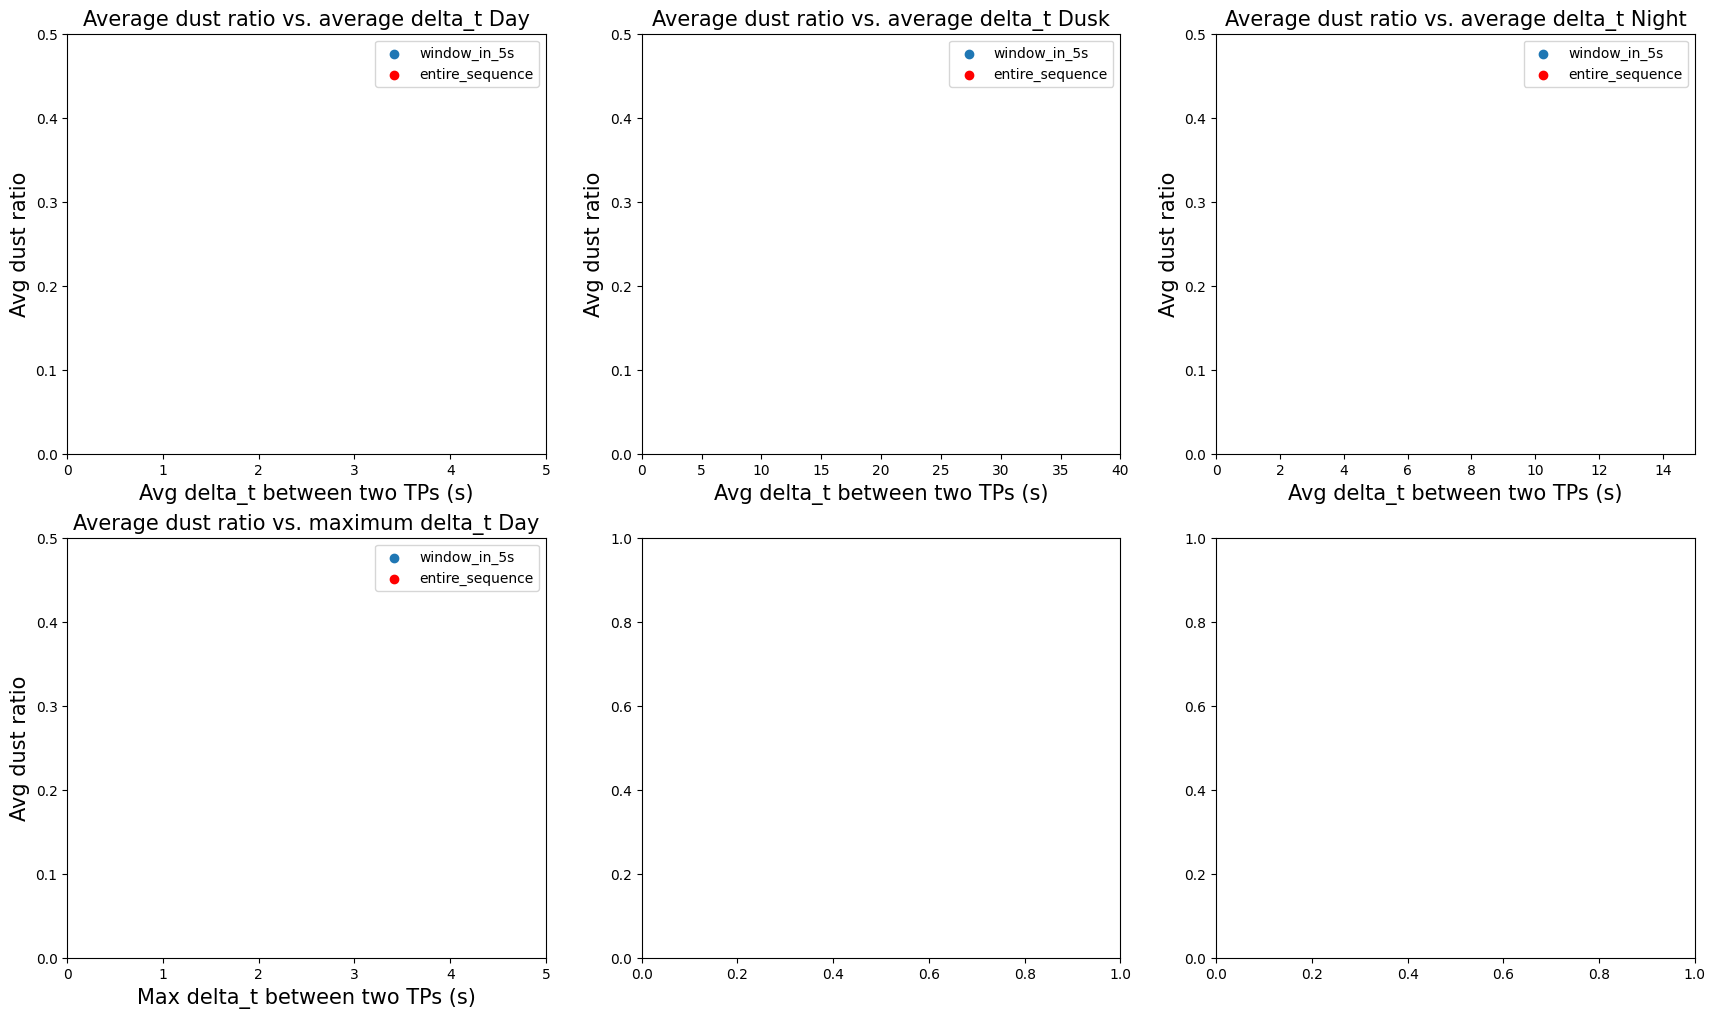

Dusk Average dust ratio vs. maximum delta_t
Night Average dust ratio vs. maximum delta_t


In [27]:
states_dicts = {'Day': day_dict, 'Dusk': dusk_dict, 'Night': night_dict}
i_list = [0,]
i = 0  # 0 for TPs, 1 for TPs and FNs
i_states = ['TP', 'TPFN']

xrange = {'Day':5, 'Dusk':40, 'Night':15}

fig, axarr = plt.subplots(2, 3, figsize=(21, 12))

def get_stats(window, partial_dict, keys=['avg_dust_ratio', 'avg_delta_t', 'max_delta_t']):
    return_dict = {}
    for key in ['avg_dust_ratio', 'avg_delta_t', 'max_delta_t']:
        out_list = []
        for camera in cameras:
            out_list.extend([states_list[i][f'{key}_{camera}{window}'][0] for collected_on, states_list in partial_dict.items() if states_list[i][f'{key}_{camera}{window}']])
        if isinstance(out_list[0], list):
            out_list = [item for sublist in out_list for item in sublist]
        return_dict[key] = out_list
    return return_dict

for ind, (t, partial_dict) in enumerate(states_dicts.items()):
    print(ind)
    ax = axarr[0][ind]
    print(t, 'Average dust ratio vs. average delta_t')
    # plt.figure(1, figsize=(8, 4))
    for window in windows:
        stats = get_stats(window, partial_dict)
        if window == '':
            ax.scatter(stats['avg_delta_t'], stats['avg_dust_ratio'], c='red', label='entire_sequence')
        else:
            ax.scatter(stats['avg_delta_t'], stats['avg_dust_ratio'], label='window_in'+window)
    ax.set_xlabel(f'Avg delta_t between two {i_states[i]}s (s)', fontsize=15)
    ax.set_ylabel('Avg dust ratio', fontsize=15)
    ax.set_title(f'Average dust ratio vs. average delta_t {t}', fontsize=15)
    ax.set_xlim([0,xrange[t]])
    ax.set_ylim([0,0.5])
    ax.legend()
    # plt.show()
#     plt.savefig(os.path.join(plot_dir, plot_name+'__avg_dust_ratio_vs_avg_delta_t'), transparent=False)
#     plt.close()

for ind, (t, partial_dict) in enumerate(states_dicts.items()):
    ax = axarr[1][ind]
    print(t, 'Average dust ratio vs. maximum delta_t')
    # plt.figure(1, figsize=(8, 4))
    for window in windows:
        stats = get_stats(window, partial_dict)
        if window == '':
            ax.scatter(stats['max_delta_t'], stats['avg_dust_ratio'], c='red', label='entire_sequence')
        else:
            ax.scatter(stats['max_delta_t'], stats['avg_dust_ratio'], label='window_in' + window)
    ax.set_title(f'Average dust ratio vs. maximum delta_t {t}', fontsize=15)
    ax.set_xlabel(f'Max delta_t between two {i_states[i]}s (s)', fontsize=15)
    ax.set_ylabel('Avg dust ratio', fontsize=15)
    ax.set_xlim([0,xrange[t]])
    ax.set_ylim([0,0.5])
    ax.legend()
    # plt.show()
#     plt.savefig(os.path.join(plot_dir, plot_name+'__avg_dust_ratio_vs_max_delta_t'), transparent=False)
#     plt.close()


## Average/maximum delta_t histograms

Day _5s
7.0
Dusk _5s
7.0
Night _5s
7.0


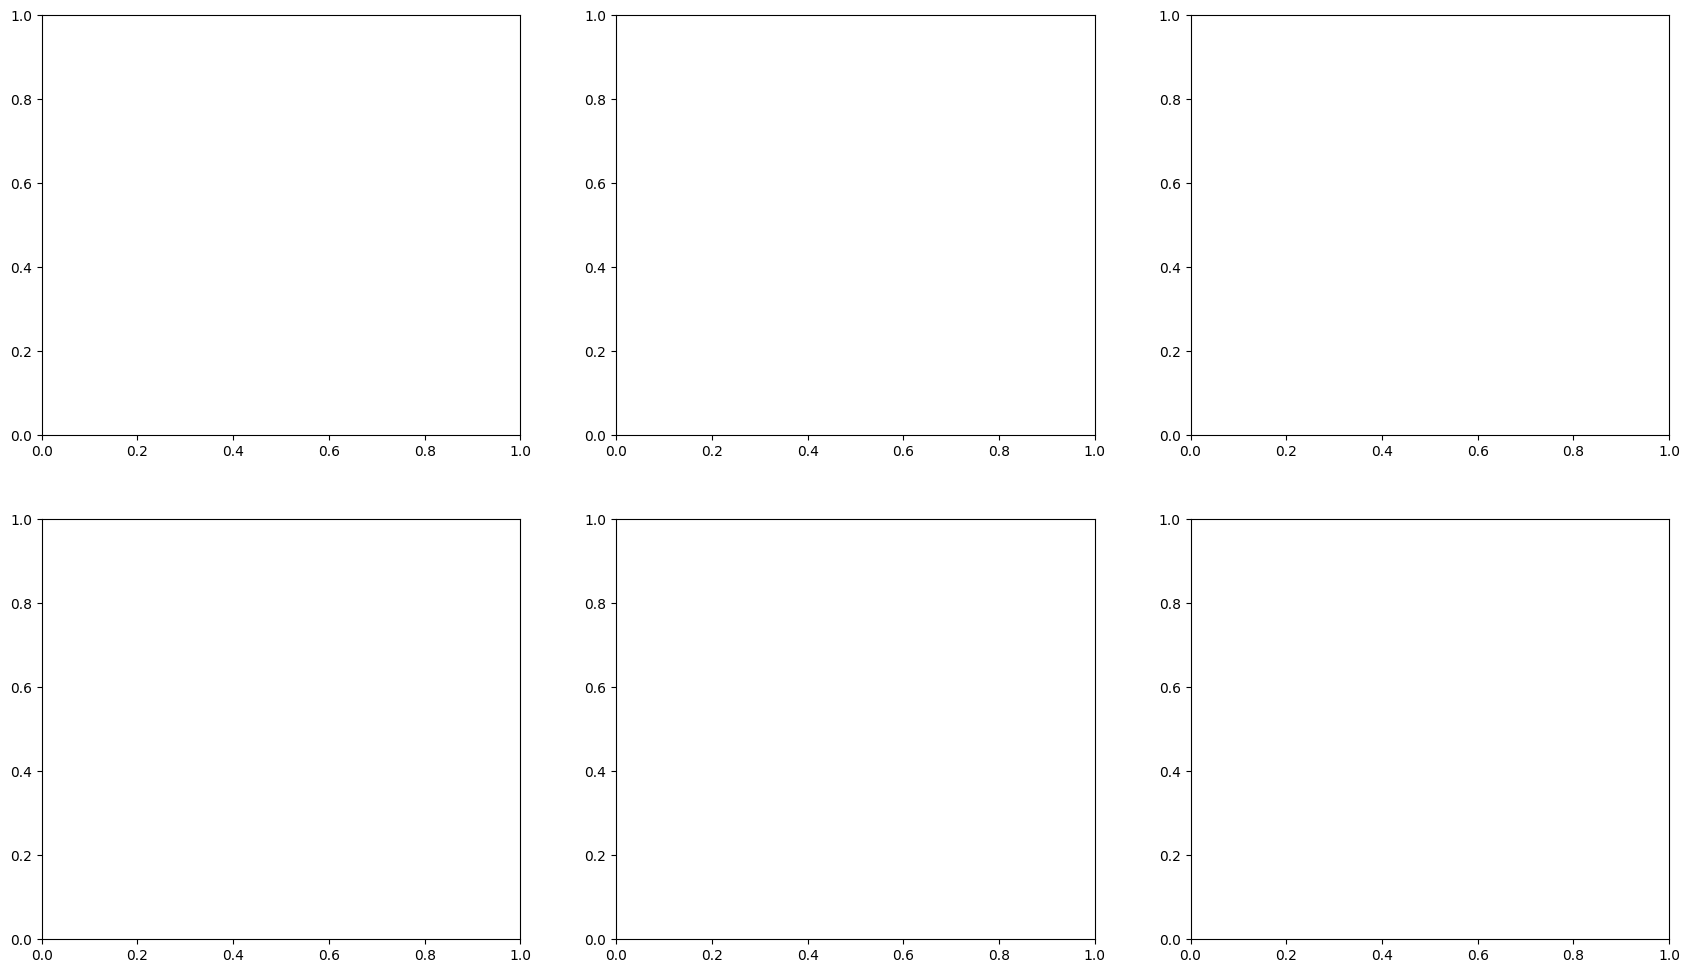

In [28]:
fig, axarr = plt.subplots(2, 3, figsize=(21, 12))

i = 0
camera = 'rear_side'
window = '_5s'  # '', '_5s', '_10s'
window_max = 7.0

for ind, (t, partial_dict) in enumerate(states_dicts.items()):
    print(t, window)
    plot_name = t+'__' + ('TP__' if i == 0 else 'TPFN__') + ('max_rear_and_side__' if camera == 'rear_side' else camera+'_') + window
    stats = get_stats(window, partial_dict, ['max_delta_t', 'avg_delta_t'])

    bins = [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,window_max]
    print(max(stats['max_delta_t']))
# title = 'Average delta_t distribution'
#     xlabel = 'Avg delta_t'
#     plot_histogram_and_cumulative(stats['avg_delta_t'], bins, title, xlabel, window_max, axarr[0][ind])

#     title = 'Maximum delta_t distribution'
#     xlabel = 'Max delta_t'
#     plot_histogram_and_cumulative(stats['max_delta_t'], bins, title, xlabel, window_max, axarr[1][ind])
    


## Miscellaneous Plots:

## Plot dust ratios and states (TP,TN,FP,FN) in image sequences

In [29]:
def plot_dust_ratio_and_state(seq_df, save_path, title='', labeled_states=False, plot_entire_image=True, plot_masked_region=False):
    seq_df['datetime'] -= seq_df.iloc[0]['datetime']
    plt.figure(1, figsize=(20, 5))
    if plot_entire_image and plot_masked_region:
        plt.subplot(121)
    states = {'true_negative': ['TN', 'blue'], 'false_positive': ['FP', 'orange']}
    if labeled_states:
        states['false_negative'] = ['FN', 'red']
        states['true_positive'] = ['TP', 'green']
    if plot_entire_image:
        for state, [label, color] in states.items():
            sub_df = seq_df[seq_df.state == state]
            if len(sub_df) > 0:
                plt.scatter(sub_df.datetime.apply(lambda x: x.total_seconds()), sub_df.total_averaged_dust_ratio, label=label, c=color)
        plt.title(seq_df.iloc[0].collected_on if len(title) == 0 else title, fontsize=15)
        plt.xlabel('Time in sequence (s)', fontsize=15)
        plt.ylabel('Dust ratio in entire image', fontsize=15)
        plt.legend()
    if plot_entire_image and plot_masked_region:
        plt.subplot(122)
    if plot_masked_region:
        for state, [label, color] in states.items():
            sub_df = seq_df[seq_df.state == state]
            if len(sub_df) > 0:
                plt.scatter(sub_df.datetime.apply(lambda x: x.total_seconds()), sub_df.triangle_averaged_dust_ratio, label=label, c=color)
        plt.title(seq_df.iloc[0].collected_on if len(title) == 0 else title, fontsize=15)
        plt.xlabel('Time in sequence (s)', fontsize=15)
        plt.ylabel('Dust ratio in triangles', fontsize=15)
        plt.legend()
    plt.show()
#     plt.savefig(save_path)
#     plt.close()

In [30]:
# plot rear camera, we care more about dust ratios in triangles, so set plot_entire_image=False, plot_masked_region=True
rear_df = df[df.camera_location == 'rear-left']
plot_dust_ratio_and_state(rear_df, save_path='', title='Rear camera', labeled_states=True, plot_entire_image=False, plot_masked_region=True)
# plot side camera, we care more about dust ratios in entire image, so set plot_entire_image=True, plot_masked_region=False
side_df = df[df.camera_location.str.startswith('side')]
plot_dust_ratio_and_state(side_df, save_path='', title='Side camera', labeled_states=True, plot_entire_image=True, plot_masked_region=False)

KeyError: 'datetime'

### Sometimes we want to plot rear and side cameras in one plot
 - Note: it could be messy if df contains multiple runs (multiple sequences of vehicles/humans passing tractor)

In [ ]:
def plot_dust_ratio_and_state_rear_pod(seq_df, save_path, plot_in_one=False, only_gt_positive=False, labeled_states=False):
    def plot_one_camera(sub_df, states, title, xlabel=False, ylabel_key='', legend_key=''):
        for state, [label, color] in states.items():
            sub_state_df = sub_df[sub_df.state == state]
            if len(sub_state_df) > 0:
                marker = "."
                dust_key = 'triangle_averaged_dust_ratio'
                if legend_key.startswith('Side left'):
                    marker = "x"
                    dust_key = 'total_averaged_dust_ratio'
                elif legend_key.startswith('Side right'):
                    marker = "+"
                    dust_key = 'total_averaged_dust_ratio'
                plt.scatter(sub_state_df.datetime.apply(lambda x: x.total_seconds()), sub_state_df[dust_key], label=legend_key+label, s=100, c=color, marker=marker)
        plt.title(sub_df.iloc[0].collected_on if len(title) == 0 else title, fontsize=15)
        plt.ylim([-0.02,0.52])
        plt.grid(True, axis='y')
        if xlabel:
            plt.xlabel('Time in sequence (s)', fontsize=15)
        plt.ylabel(f'Dust ratio{ylabel_key}', fontsize=15)
        plt.legend()
    
    if only_gt_positive:
        seq_df = seq_df[(seq_df.state == 'false_negative') | (seq_df.state == 'true_positive')]
    
    seq_df['datetime'] -= seq_df.iloc[0]['datetime']
    states = {'true_negative': ['TN', 'blue'], 'false_positive': ['FP', 'orange']}
    if labeled_states:
        states['false_negative'] = ['FN', 'red']
        states['true_positive'] = ['TP', 'green']
    
    side_left_df = seq_df[seq_df.camera_location == 'side-left-left']
    rear_df = seq_df[seq_df.camera_location == 'rear-left']
    side_right_df = seq_df[seq_df.camera_location == 'side-right-left']
    if plot_in_one:
#         title = f'{seq_df.iloc[0].collected_on} Rear'
        title = 'Rear'
        plt.figure(1, figsize=(20, 5))
        if len(side_left_df[(side_left_df.state == 'false_negative') | (side_left_df.state == 'true_positive')]) > 0:
            plot_one_camera(side_left_df, states, '', False, '', 'Side left ')
            title += ' with Side left'
        if len(side_right_df[(side_right_df.state == 'false_negative') | (side_right_df.state == 'true_positive')]) > 0:
            plot_one_camera(side_right_df, states, '', False, '', 'Side right ')
            title += ' with Side right'
        plot_one_camera(rear_df, states, title, True, '', 'Rear ')
    else:
        plt.figure(1, figsize=(20, 15))
        plt.subplot(311)
        plot_one_camera(side_left_df, states, 'Side-left', False, ' in entire image', 'Side left ')
        plt.subplot(312)
        plot_one_camera(rear_df, states, 'Rear', False, ' in triangles', 'Rear ')
        plt.subplot(313)
        plot_one_camera(side_right_df, states, 'Side-right', True, ' in entire image', 'Side right ')
    plt.show()
#     plt.savefig(save_path, transparent=False)
#     plt.close()

/tmp/ipykernel_40173/1699483782.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq_df['datetime'] -= seq_df.iloc[0]['datetime']


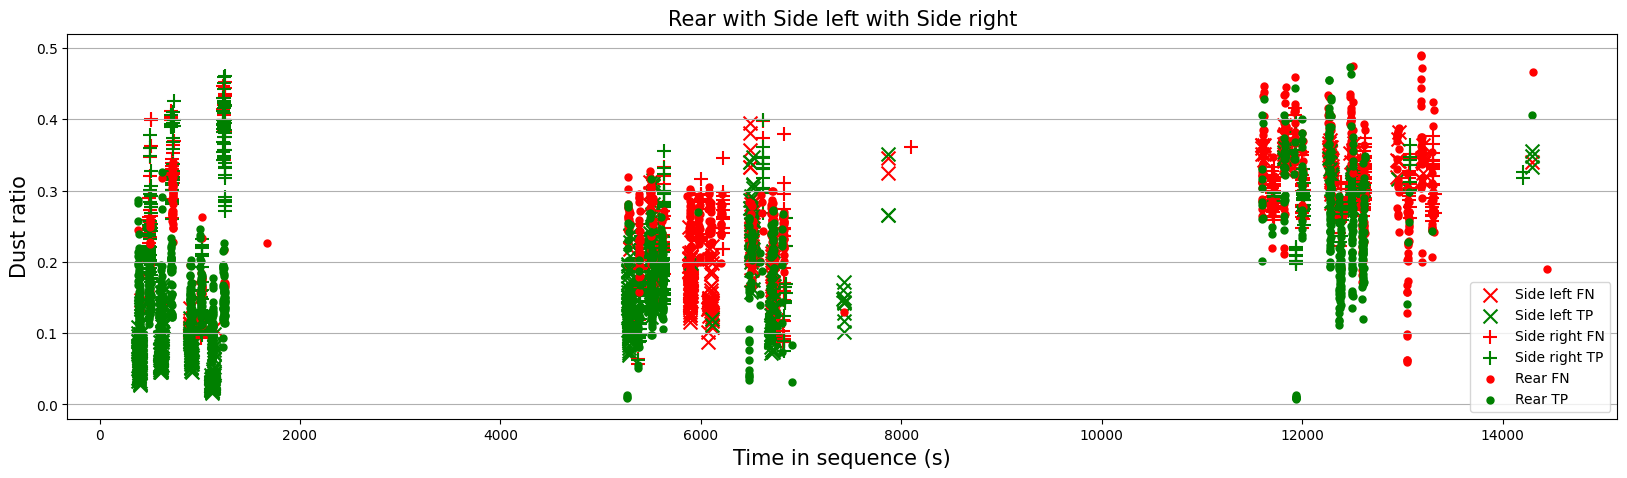

In [ ]:
plot_dust_ratio_and_state_rear_pod(df, save_path='', plot_in_one=True, only_gt_positive=True, labeled_states=True)

## Plot states vs. dust ratio for front pod

(1213, 22) (1186, 22)


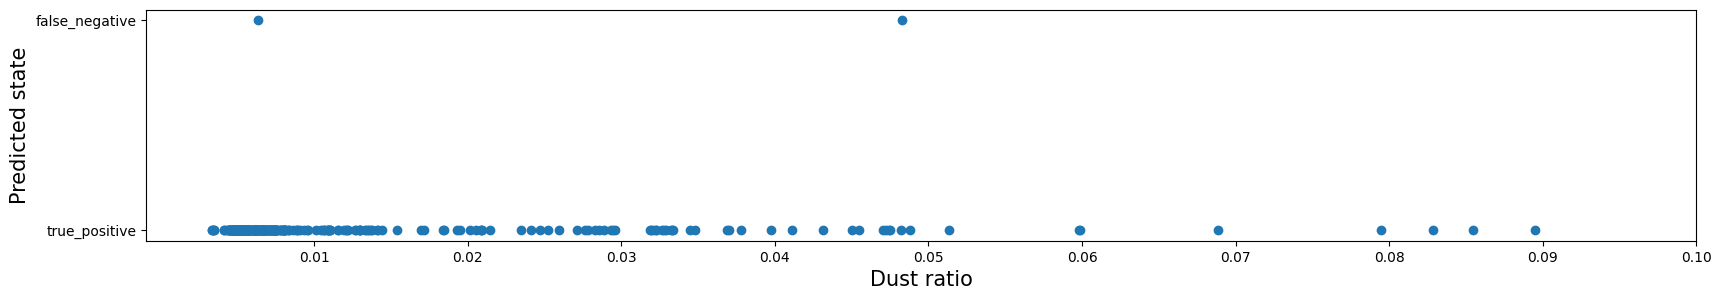

In [ ]:
fpdf = pdf[(pdf.camera_location.str.startswith('front')) & (pdf.Vehicles > 0)]
print(fpdf.shape, fpdf[fpdf.state == 'true_positive'].shape)
plt.figure(1, figsize=(20, 3))
# plt.scatter(fpdf.pred_dust_ratio, fpdf.state)  # 7-class model dust head
plt.scatter(fpdf.total_averaged_dust_ratio, fpdf.state)  # 8 or 4 class model dust class
plt.xticks([x*0.01 for x in range(1, 11)])
plt.xlabel('Dust ratio', fontsize=15)
plt.ylabel('Predicted state', fontsize=15)
plt.show()

In [ ]:
fpdf[fpdf.id == '64429249cd141369ec143c67'].camera_location

37367    front-right-left
Name: camera_location, dtype: object

In [ ]:
fpdf[fpdf.pred_dust_ratio > 0.01].id.to_list()

[]

In [ ]:
collected_on = df2[df2.id == '64429249cd141369ec143c67'].iloc[0].collected_on
collected_on

'2023-04-05T17:10:09.569000'

In [ ]:
df2[(df2.camera_location == 'side-right-left') & (df2.collected_on >= '2023-04-05T17:10:09.069000') & (df2.collected_on <= '2023-04-05T17:10:09.969000')][['id', 'collected_on']]

,id,collected_on
4938,6442d7150c717c2db1497342,2023-04-05T17:10:09.161000
1309,6442d63c94903883d9ef5432,2023-04-05T17:10:09.480000
5930,6442d6e8895db77d52e3a6e7,2023-04-05T17:10:09.822000


In [ ]:
pdf[pdf.id == '6442d63c94903883d9ef5432'].state

37365    true_positive
Name: state, dtype: object

In [166]:
np.sum(pdf['speed'] < 2)

22

(1251, 22) (1172, 22)


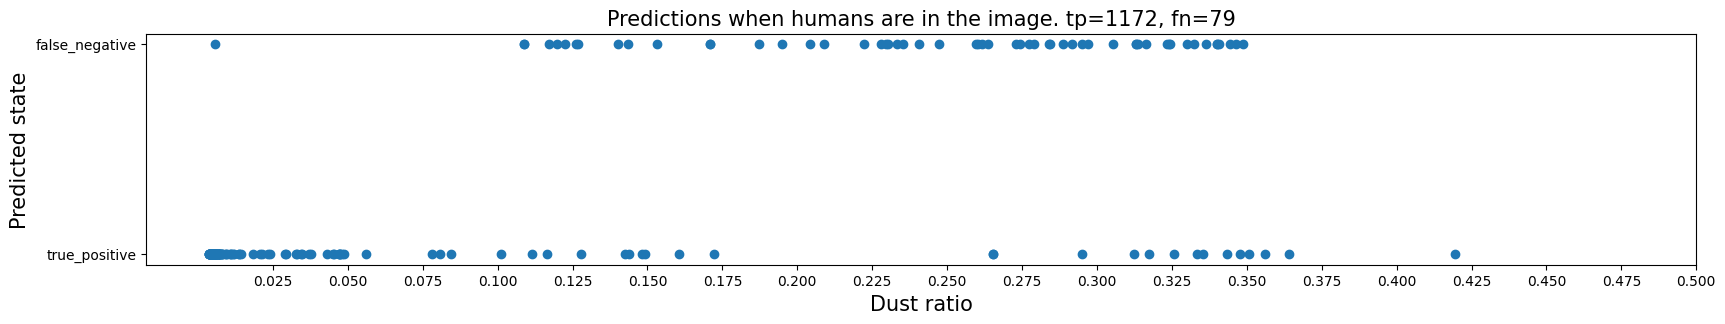

In [197]:
fpdf = pdf[(pdf.Humans > 0)]
tps = fpdf[fpdf.state == 'true_positive'].shape[0]
fns = fpdf.shape[0] - tps
print(fpdf.shape, fpdf[fpdf.state == 'true_positive'].shape)
plt.figure(1, figsize=(20, 3))
# plt.scatter(fpdf.pred_dust_ratio, fpdf.state)  # 7-class model dust head
plt.scatter(fpdf.total_averaged_dust_ratio, fpdf.state)  # 8 or 4 class model dust class
plt.xticks([x*0.025 for x in range(1, 21)])
plt.xlabel('Dust ratio', fontsize=15)
plt.ylabel('Predicted state', fontsize=15)
plt.title(f'Predictions when humans are in the image. tp={tps}, fn={fns}', fontsize=15)
plt.show()